In [ ]:
! pip install gym
! pip install pygame

## Custom environment

In [5]:
# Built-in
import random
import time

# Gym
import gym
from gym import spaces

# Numpy
import numpy as np
from numpy.random import randint

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# GUI
import matplotlib.pyplot as plt
import pygame

# Buffer
from collections import deque


Little function to make experiments reproducible.

In [6]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

Extending the gym.Env class from Open AI, we create our custom environment.

In [7]:
class KnightKingEnv(gym.Env):

    knight_moves = [ (-2, +1),
                     (-1, +2),
                     (+1, +2),
                     (+2, +1),
                     (+2, -1),
                     (+1, -2),
                     (-1, -2),
                     (-2, -1) ]

    def __init__(self):
        super(KnightKingEnv, self).__init__()
        self.board_size = 8
        self.action_space = spaces.Discrete(8) # knight's moves
        self.observation_space = spaces.Box(low=0, high=self.board_size-1, shape=(4,), dtype=np.int32)
        self.max_moves = 10
    
    def reset(self):
        self.knight_pos = self._set_position()
        self.king_pos = self._set_position(avoid=[self.knight_pos])
        while self._is_check():
            self.king_pos = self._set_position(avoid=[self.knight_pos])
        self.legal_moves = 0
        self.illegal_moves = 0
        self.win = None
        self.out_of_moves = False
        return self._get_observation()

    def step(self, action):
        has_moved = self._move_knight(action)
        reward = -1
        done = False

        # illegal move
        if not has_moved:
            reward = -5
            self.illegal_moves += 1
        
        # legal move
        else:
            self.legal_moves += 1
            
            # knight is under attack
            if self._is_under_attack():
                reward = -10
                done = True
                self.win = False
            
            # knight has checked
            elif self._is_check():
                reward = +10
                done = True
                self.win = True
        
        # out of moves
        if self.legal_moves+self.illegal_moves >= self.max_moves:
            reward = -5
            done = True
            self.win = False
            self.out_of_moves = True

        return self._get_observation(), reward, done, {}

    def _move_knight(self, action):
        move = self.knight_moves[action]
        new_pos = (self.knight_pos[0] + move[0],
                    self.knight_pos[1] + move[1])
        if self._is_legal(new_pos):
            self.knight_pos = new_pos
            return True
        return False

    def _is_legal(self, pos):
        if pos[0] >= 0 and pos[0] < self.board_size:
            if pos[1] >= 0 and pos[1] < self.board_size:
                return True
        return False

    def _is_check(self):
        for move in self.knight_moves:
            check_pos = (self.knight_pos[0] + move[0],
                         self.knight_pos[1] + move[1])
            if check_pos == self.king_pos:
                return True
        return False 

    def _is_under_attack(self):
        all_moves = [(self.king_pos[0]-1, self.king_pos[1]-1),
                    (self.king_pos[0]-1, self.king_pos[1]),
                    (self.king_pos[0]-1, self.king_pos[1]+1),
                    (self.king_pos[0], self.king_pos[1]+1),
                    (self.king_pos[0]+1, self.king_pos[1]+1),
                    (self.king_pos[0]+1, self.king_pos[1]),
                    (self.king_pos[0]+1, self.king_pos[1]-1),
                    (self.king_pos[0], self.king_pos[1]-1)]
        attacked = []
        for move in all_moves:
            if self._is_legal(move):
                attacked.append(move)
        if self.knight_pos in attacked:
            return True
        return False

    def _set_position(self, avoid=[]):
        while True:
            pos = (randint(self.board_size), randint(self.board_size))
            if pos not in avoid:
                return pos

    def _get_observation(self):
        obs = np.array([self.knight_pos[0], self.knight_pos[1],
                        self.king_pos[0], self.king_pos[1]])
        return obs

The following block samples a random state from the custom environment and prints it on the console. It also performs a random action. This is only for debug purposes. `K` is Knight, `R` is King ("Re").

In [10]:
def print_chessboard(positions, board_size=8):
    knight_x, knight_y, king_x, king_y = positions
    board = [['.' for _ in range(board_size)] for _ in range(board_size)]
    board[knight_x][knight_y] = 'K'
    board[king_x][king_y] = 'R'
    for row in board:
        print(' '.join(row))
    print()

def dummy_env():
    env = KnightKingEnv()
    state = env.reset()
    print_chessboard(state)
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    print_chessboard(state)
    print(f"Action: {action}, Reward: {reward}, Done: {done}")
    env.close()

dummy_env()

. . . . . . . .
. . . . . . . .
. . . . . . R .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .

. . . . . . . .
. . . . . . . .
. . . . . . R .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .

Action: 6, Reward: -5, Done: False


## Deep Q-Network

The Deep Neural Network consists of a stack of linear layers with ReLUs in between. It takes as input the 4 coordinates of the pieces (knight x, knight y, king x, king y) and it outputs a 8 dimensional vector that is the knight's possible moves.

In [11]:
class DQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Here we experiment with different epsilon decay rates. We also plot the corresponding graphs. We fix a total number of steps and calibrate the decay rate accordingly. We try to find a good balance between exploration (high epsilon) and exploitation (low epsilon).

In [12]:
num_steps = 20_000

# Parameters
hp_exp_decay = {
    "epsilon_max" : 0.9,
    "epsilon_min" : 0.1,
    "decay_rate" : 0.0005
}

hp_linear_decay = {
    "epsilon_max" : 0.9,
    "epsilon_min" : 0.1,
    "decay_steps" : 4000,  # Number of steps over which epsilon decays
}
hp_linear_decay["decay_rate"] = (hp_linear_decay["epsilon_max"] - hp_linear_decay["epsilon_min"]) / hp_linear_decay["decay_steps"]

hp_custom_decay = {
    "epsilon_max" : 0.9,
    "epsilon_min" : 0.1,
    "decay_rate" : 0.9995
}

def epsilon_exp_decay(t, epsilon_max, epsilon_min, decay_rate):
    return epsilon_min + (epsilon_max - epsilon_min) * np.exp(-decay_rate * t)

def epsilon_linear_decay(t, epsilon_max, epsilon_min, decay_rate):
    return max(epsilon_min, epsilon_max - decay_rate * t)

def epsilon_custom_decay(t, epsilon_max, epsilon_min, decay_rate):
    ans = epsilon_max * (decay_rate**t)
    if ans < epsilon_min:
        return epsilon_min
    return ans

epsilon_values_exp = [epsilon_exp_decay(t, 
                                        hp_exp_decay["epsilon_max"], 
                                        hp_exp_decay["epsilon_min"],
                                        hp_exp_decay["decay_rate"]) for t in range(num_steps)]

epsilon_values_lin = [epsilon_linear_decay(t,
                                           hp_linear_decay["epsilon_max"], 
                                           hp_linear_decay["epsilon_min"],
                                           hp_linear_decay["decay_rate"]) for t in range(num_steps)]

epsilon_values_custom = [epsilon_custom_decay(t,
                                              hp_custom_decay["epsilon_max"], 
                                              hp_custom_decay["epsilon_min"],
                                              hp_custom_decay["decay_rate"]) for t in range(num_steps)]


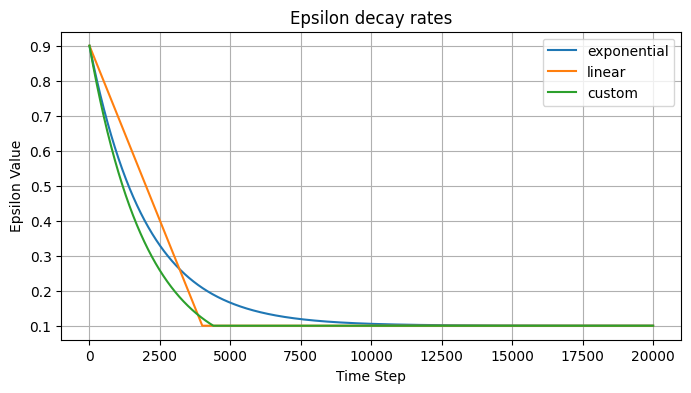

In [13]:
plt.figure(figsize=[8,4])
plt.plot(epsilon_values_exp, label="exponential")
plt.plot(epsilon_values_lin, label="linear")
plt.plot(epsilon_values_custom, label="custom")
plt.title('Epsilon decay rates')
plt.xlabel('Time Step')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.legend()
plt.show()


Now we define the training loop of the DQN model.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_dqn(num_episodes, batch_size, gamma, epsilon_max, epsilon_min, decay_rate):
    env = KnightKingEnv()
    input_dim = 4 # Knight x, Knight y, King x, King y
    num_actions = env.action_space.n # 8 possible moves
    epsilon = epsilon_max

    policy_net = DQN(input_dim, num_actions).to(device)
    target_net = DQN(input_dim, num_actions).to(device)

    # train only the policy network, update target net periodically
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
    mse_loss = nn.MSELoss()
    replay_buffer = deque(maxlen=1000)
    list_cum_reward = np.zeros(num_episodes)

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        cum_reward = 0
        step = 0
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample() # EXPLORE
            else:
                with torch.no_grad():
                    action = policy_net(state).argmax().item() # EXPLOIT
            
            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
            replay_buffer.append((state, action, reward, next_state, done))

            state = next_state
            cum_reward += reward
            step += 1

            # Train the policy network sampling from the buffer
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)

                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.cat(states).to(device)
                actions = torch.tensor(actions).to(device)
                rewards = torch.tensor(rewards).to(device)
                next_states = torch.cat(next_states).to(device)
                dones = torch.tensor(dones, dtype=int).to(device)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(next_states).max(1)[0]
                target_q_values = rewards + gamma * next_q_values * (1 - dones)

                loss = mse_loss(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Update target network after 100 steps
            if step % 100 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            # Decay epsilon
            epsilon = epsilon_custom_decay(episode, epsilon_max, epsilon_min, decay_rate)
            
            if done:
                break
        
        list_cum_reward[episode] = cum_reward
        if (episode + 1) % 100 == 0:
            print(f"[{episode + 1}/{num_episodes}], Avg. Reward: {np.mean(list_cum_reward[:episode]):.4f}, Epsilon: {epsilon:.6f}")
    
    env.close()
    return policy_net, list_cum_reward

In [15]:
dqn, dqn_rewards = train_dqn(num_episodes = 20_000,
                             batch_size = 64,
                             gamma = 0.99,
                             epsilon_max = hp_custom_decay["epsilon_max"],
                             epsilon_min = hp_custom_decay["epsilon_min"],
                             decay_rate = hp_custom_decay["decay_rate"])

[100/20000], Avg. Reward: -16.6263, Epsilon: 0.856524
[200/20000], Avg. Reward: -14.7286, Epsilon: 0.814741
[300/20000], Avg. Reward: -14.0268, Epsilon: 0.774996
[400/20000], Avg. Reward: -13.1203, Epsilon: 0.737189
[500/20000], Avg. Reward: -12.7515, Epsilon: 0.701227
[600/20000], Avg. Reward: -12.3823, Epsilon: 0.667020
[700/20000], Avg. Reward: -12.0844, Epsilon: 0.634481
[800/20000], Avg. Reward: -11.8110, Epsilon: 0.603529
[900/20000], Avg. Reward: -11.7119, Epsilon: 0.574088
[1000/20000], Avg. Reward: -11.5055, Epsilon: 0.546082
[1100/20000], Avg. Reward: -11.1993, Epsilon: 0.519443
[1200/20000], Avg. Reward: -10.9258, Epsilon: 0.494103
[1300/20000], Avg. Reward: -10.7421, Epsilon: 0.470000
[1400/20000], Avg. Reward: -10.4911, Epsilon: 0.447072
[1500/20000], Avg. Reward: -10.3262, Epsilon: 0.425263
[1600/20000], Avg. Reward: -10.0069, Epsilon: 0.404517
[1700/20000], Avg. Reward: -9.6928, Epsilon: 0.384784
[1800/20000], Avg. Reward: -9.4869, Epsilon: 0.366013
[1900/20000], Avg. Re

In [16]:
# Save and load DQN parameters
# torch.save(dqn.state_dict(), "weights/dqn_20000.pth")
dqn.load_state_dict(torch.load("weights/dqn_20000.pth"))

## Actor-Critic policy approximation

AC method constists of 2 networks: the actor and the critic.

In [19]:
class Actor(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Now we define the training loop for the AC agent.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_ac(num_episodes, gamma):
    env = KnightKingEnv()
    input_dim = 4
    num_actions = env.action_space.n

    actor = Actor(input_dim, num_actions).to(device)
    critic = Critic(input_dim).to(device)

    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
    critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

    list_cum_reward = np.zeros(num_episodes)

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        done = False
        cum_reward = 0

        while not done:
            action_prob = actor(state)
            action = torch.multinomial(action_prob, 1).item()
            
            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

            td_target = reward + (1 - done) * gamma * critic(next_state)
            td_error = td_target - critic(state)

            critic_loss = td_error ** 2
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            log_prob = torch.log(action_prob.squeeze(0)[action])
            actor_loss = -log_prob * td_error.detach()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            state = next_state
            cum_reward += reward

        list_cum_reward[episode] = cum_reward
        if (episode + 1) % 100 == 0:
            print(f"[{episode +1}/{num_episodes}], Avg. Reward: {np.mean(list_cum_reward[:episode]):.4f}")
    
    env.close()
    return actor, list_cum_reward

In [21]:
ac, ac_rewards = train_ac(num_episodes = 20_000, gamma = 0.99)

[100/20000], Avg. Reward: -15.7576
[200/20000], Avg. Reward: -13.8191
[300/20000], Avg. Reward: -13.3411
[400/20000], Avg. Reward: -11.5915
[500/20000], Avg. Reward: -11.2104
[600/20000], Avg. Reward: -10.4057
[700/20000], Avg. Reward: -9.5536
[800/20000], Avg. Reward: -9.2253
[900/20000], Avg. Reward: -8.9622
[1000/20000], Avg. Reward: -8.6276
[1100/20000], Avg. Reward: -8.2857
[1200/20000], Avg. Reward: -8.0901
[1300/20000], Avg. Reward: -7.7791
[1400/20000], Avg. Reward: -7.5197
[1500/20000], Avg. Reward: -7.1788
[1600/20000], Avg. Reward: -7.0025
[1700/20000], Avg. Reward: -6.8499
[1800/20000], Avg. Reward: -6.7326
[1900/20000], Avg. Reward: -6.6072
[2000/20000], Avg. Reward: -6.3837
[2100/20000], Avg. Reward: -6.3016
[2200/20000], Avg. Reward: -6.1392
[2300/20000], Avg. Reward: -6.0635
[2400/20000], Avg. Reward: -5.9541
[2500/20000], Avg. Reward: -5.8860
[2600/20000], Avg. Reward: -5.7999
[2700/20000], Avg. Reward: -5.7166
[2800/20000], Avg. Reward: -5.6920
[2900/20000], Avg. Rewa

In [22]:
# Save and load AC parameters
torch.save(ac.state_dict(), "weights/ac_20000.pth")
# ac.load_state_dict(torch.load("weights/ac_20000.pth"))

We also trace the average cumulative reward for the random agent only for plotting purposes.

In [23]:
def train_ac(num_episodes):
    env = KnightKingEnv()
    list_cum_reward = np.zeros(num_episodes)

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        cum_reward = 0

        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            cum_reward += reward

            if done:
                break

        list_cum_reward[episode] = cum_reward
        if (episode + 1) % 100 == 0:
            print(f"[{episode +1}/{num_episodes}], Avg. Reward: {np.mean(list_cum_reward[:episode]):.4f}")
    
    env.close()
    return list_cum_reward

In [24]:
random_rewards = train_ac(num_episodes=20_000)

[100/20000], Avg. Reward: -18.1414
[200/20000], Avg. Reward: -17.8442
[300/20000], Avg. Reward: -18.6789
[400/20000], Avg. Reward: -18.8296
[500/20000], Avg. Reward: -18.8677
[600/20000], Avg. Reward: -18.2838
[700/20000], Avg. Reward: -18.1531
[800/20000], Avg. Reward: -18.2240
[900/20000], Avg. Reward: -17.8209
[1000/20000], Avg. Reward: -17.7417
[1100/20000], Avg. Reward: -17.7816
[1200/20000], Avg. Reward: -17.9475
[1300/20000], Avg. Reward: -17.9176
[1400/20000], Avg. Reward: -17.7048
[1500/20000], Avg. Reward: -17.7665
[1600/20000], Avg. Reward: -17.7017
[1700/20000], Avg. Reward: -17.8817
[1800/20000], Avg. Reward: -17.9589
[1900/20000], Avg. Reward: -17.9084
[2000/20000], Avg. Reward: -17.7779
[2100/20000], Avg. Reward: -17.6556
[2200/20000], Avg. Reward: -17.5716
[2300/20000], Avg. Reward: -17.3954
[2400/20000], Avg. Reward: -17.3889
[2500/20000], Avg. Reward: -17.3802
[2600/20000], Avg. Reward: -17.3205
[2700/20000], Avg. Reward: -17.3661
[2800/20000], Avg. Reward: -17.3594
[

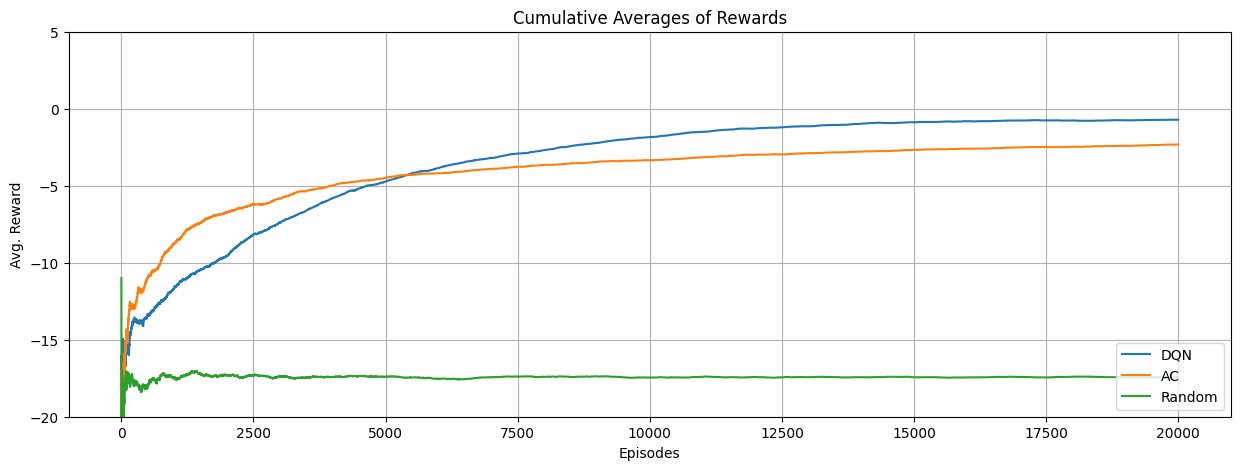

In [56]:
def cumulative_average(rewards):
    cumulative_sum = np.cumsum(rewards)
    cumulative_count = np.arange(1, len(rewards) + 1)
    averages = cumulative_sum / cumulative_count
    return averages 

episode_min = 0
episode_max = 20_000
episode_step = 1
plt.figure(figsize=(15, 5))
plt.plot(cumulative_average(dqn_rewards[episode_min:episode_max:episode_step]), label="DQN")
plt.plot(cumulative_average(ac_rewards[episode_min:episode_max:episode_step]), label="AC")
plt.plot(cumulative_average(random_rewards[episode_min:episode_max:episode_step]), label="Random")
plt.title("Cumulative Averages of Rewards")
plt.xlabel("Episodes")
plt.ylabel("Avg. Reward")
plt.legend(loc="lower right")
plt.ylim(-20, 5)
plt.grid(True)
plt.show()

## Evaluation
In this section we compare the performances of our trained agents against the random baseline. We choose several evaluation metrics to assess the performace of our model. The metrics are all averages and are computed after a sufficient amount of episodes. The metrics are (1) cumulative reward, (2) number of legal moves, (3) number of illegal moves, (4) winning probability, (5) exceeding max move length probability.

In [57]:
def evaluate(agent : str, n_games : int, model=None):
    if agent not in {"random", "dqn", "ac"}:
        raise ValueError("The agent must be random, dqn, or ac.")

    print(f"Evaluating {agent}...")

    # Set the model to evaluation mode
    if model is not None and isinstance(model, nn.Module):
        print("Set to eval mode...")
        model.eval()

    env = KnightKingEnv()
    list_cum_reward = []
    list_legal_moves = []
    list_illegal_moves = []
    list_wins = []
    list_out_of_moves = []
    
    for game in range(n_games):
        cum_reward = 0
        done = False
        state = env.reset()

        while not done:
            if agent == "random":
                action = env.action_space.sample()
            
            elif agent == "dqn":
                with torch.no_grad():
                    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = model(state).argmax().item()
            else:
                with torch.no_grad():
                    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action_prob = model(state)
                    action = torch.multinomial(action_prob, 1).item()

            next_state, reward, done, info = env.step(action)
            state = next_state
            cum_reward += reward
        
        list_cum_reward.append(cum_reward)
        list_legal_moves.append(env.legal_moves)
        list_illegal_moves.append(env.illegal_moves)
        list_wins.append(env.win)
        list_out_of_moves.append(env.out_of_moves)
    
    # compute averages
    avg_cum_reward = np.mean(list_cum_reward)
    avg_legal_moves = np.mean(list_legal_moves)
    avg_illegal_moves = np.mean(list_illegal_moves)
    avg_wins = np.mean(list_wins)
    avg_out_of_moves = np.mean(list_out_of_moves)

    env.close()
    return avg_cum_reward, avg_legal_moves, avg_illegal_moves, avg_wins, avg_out_of_moves


In [58]:
metrics_dict = {}
metrics_dict["random"] = evaluate(agent="random", n_games=1000, model=None)
metrics_dict["dqn"] = evaluate(agent="dqn", n_games=1000, model=dqn) 
metrics_dict["ac"] = evaluate(agent="ac", n_games=1000, model=ac)

Evaluating random...
Evaluating dqn...
Set to eval mode...
Evaluating ac...
Set to eval mode...


In [60]:
import json
with open('metrics.json', 'w') as file:
    json.dump(metrics_dict, file, indent=4)

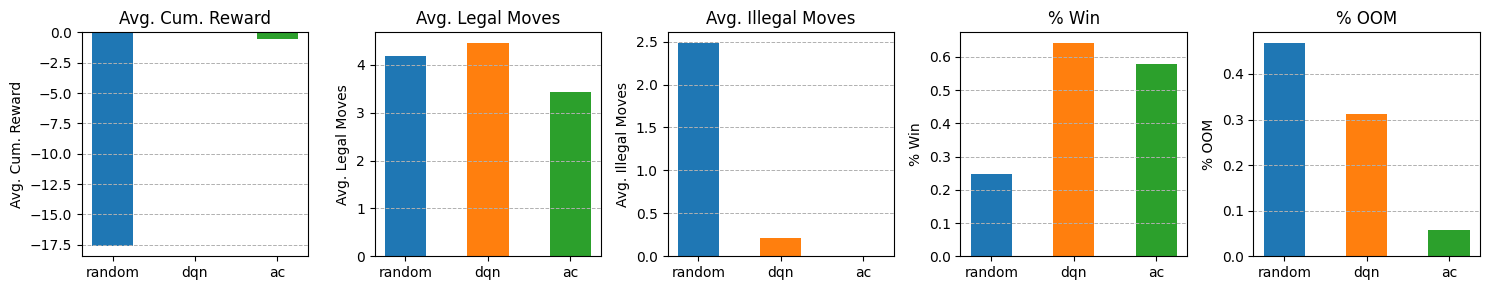

In [59]:
metric_names = ["Avg. Cum. Reward", "Avg. Legal Moves", "Avg. Illegal Moves", "% Win", "% OOM"]
n_metrics = len(metric_names)
n_models = len(metrics_dict)
fig, axes = plt.subplots(1, n_metrics, figsize=(15, 3))
bar_width = 0.5
indices = np.arange(n_models) # 0, 1, 2

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    for j, (model_name, metrics) in enumerate(metrics_dict.items()):
        ax.bar(j, metrics[i], bar_width, label=model_name)

    ax.grid(axis='y', linestyle='--', linewidth=0.7)
    ax.set_ylabel(metric_name)
    ax.set_title(f"{metric_name}")
    ax.set_xticks(indices)
    ax.set_xticklabels(metrics_dict.keys())

plt.tight_layout()
plt.show()

## Let's play!
Now it's time to see how the agent moves the knight on the board. To do this, we use a graphic library called pygame, that easily allows us to display the chessboard and the pieces on the screen. 

In [25]:
class ChessBoard:

    # Constants
    BOARD_COLOR1 = (240, 217, 181)
    BOARD_COLOR2 = (181, 136, 99)
    BLACK = (0, 0, 0)
    SQUARE_SIZE = 60
    BOARD_SIZE = 8
    SCREEN_SIZE = BOARD_SIZE * SQUARE_SIZE

    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((self.SCREEN_SIZE, self.SCREEN_SIZE))
        pygame.display.set_caption("Knight vs King")

        self.knight_img = pygame.image.load("img/black_knight.png")
        self.king_img = pygame.image.load("img/white_king.png")
        
        self.knight_img = pygame.transform.scale(self.knight_img, (self.SQUARE_SIZE, self.SQUARE_SIZE))
        self.king_img = pygame.transform.scale(self.king_img, (self.SQUARE_SIZE, self.SQUARE_SIZE))

        self.env = KnightKingEnv()

    def draw_chessboard(self, positions):
        # Draw the squares
        for row in range(self.BOARD_SIZE):
            for col in range(self.BOARD_SIZE):
                color = self.BOARD_COLOR1 if (row + col) % 2 == 0 else self.BOARD_COLOR2
                square = (col * self.SQUARE_SIZE, row * self.SQUARE_SIZE, 
                          self.SQUARE_SIZE, self.SQUARE_SIZE)
                pygame.draw.rect(self.screen, color, square)

        # Draw the pieces
        knight_x, knight_y, king_x, king_y = positions
        self.screen.blit(self.knight_img, (knight_x * self.SQUARE_SIZE, knight_y * self.SQUARE_SIZE))
        self.screen.blit(self.king_img, (king_x * self.SQUARE_SIZE, king_y * self.SQUARE_SIZE))

    def update_display(self, positions):
        self.screen.fill(self.BLACK)
        self.draw_chessboard(positions)
        pygame.display.flip()

    def play(self, agent : str, n_games : int, model=None):
        if agent not in {"random", "dqn", "ac"}:
            raise ValueError("The agent must be random, dqn, or ac.")

        print(f"{agent} is playing...")

        # Set the model to evaluation mode
        if model is not None and isinstance(model, nn.Module):
            model.eval()

        running = True
        for game in range(n_games):
            if not running:
                break
            done = False
            state = self.env.reset()
            self.update_display(state)
            time.sleep(1.0)

            while not done and running:
                # Check events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                        print("Quitting...")
                
                # Pick action
                if agent == "random":
                    action = self.env.action_space.sample()

                elif agent == "dqn":
                    with torch.no_grad():
                        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                        action = model(state).argmax().item()
                
                else:
                    with torch.no_grad():
                        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                        action_prob = model(state)
                        action = torch.multinomial(action_prob, 1).item()
                
                # Move to next state
                next_state, reward, done, info = self.env.step(action)
                state = next_state

                self.update_display(state)
                time.sleep(1.0)

        self.env.close()
        pygame.quit()

board = ChessBoard()
board.play(agent="dqn", n_games=50, model=dqn)

dqn is playing...
Quitting...
